# Title: Using Regression Analysis to Predict the Performance of a Student

### Introduction

A student's performance is not only influenced by how hard they work; it can be affected by many factors, including school quality, relationships, health conditions, and so on. The question is, how can one accurately predict the performance of a student?

Using a dataset made by Paulo Cortez, we are able to answer the question above. The dataset contains data collected using school reports and questionnaires from two Portuguese secondary schools, and includes the first period, second period, and final grades of numerous students. It also tracks various social and health related information, ranging from family situations to alcohol consumption. Since the original dataset includes too many variables to reasonably consider, the variables we use has been filtered and narrowed down to a manageable amount. In this project, we are only interested in predicting a student's math performance.

### Preliminary exploratory data analysis

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [9]:
# reading the dataset into R
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip", temp)
data <- read_delim(unz(temp, "student-mat.csv"), delim = ";") %>% 
        select(age, absences, G1, G2, G3)
unlink(temp)

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



In [3]:
# splitting data into training data/testing data
data_split <- initial_split(data, prop = 0.75, strata = G3)

training_data <- training(data_split)
testing_data <- testing(data_split)

training_data
testing_data

age,absences,G1,G2,G3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
17,4,5,5,6
16,10,15,15,15
16,0,12,12,11
⋮,⋮,⋮,⋮,⋮
17,3,14,16,16
18,0,11,12,10
19,5,8,9,9


age,absences,G1,G2,G3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,6,5,6,6
15,10,7,8,10
15,2,15,14,15
⋮,⋮,⋮,⋮,⋮
19,0,6,5,0
18,14,6,5,5
21,3,10,8,7


In [4]:
# Summarizing training data
training_count <- training_data %>% 
    summarize(count = n()) 

# Counting missing values
missing_count <- training_data %>% 
    summarize(missing_G1 = sum(is.na(G1)), missing_G2 = sum(is.na(G2)), missing_G3 = sum(is.na(G3)))

# Mean of Grades
training_mean <- training_data %>% 
    summarize(mean_G1 = mean(G1), mean_G2 = mean(G2), mean_G3 = mean(G3))

training_summary <- training_count %>% 
    bind_cols( missing_count, training_mean)

training_summary

count,missing_G1,missing_G2,missing_G3,mean_G1,mean_G2,mean_G3
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
298,0,0,0,11,10.71812,10.39933


In [7]:
# Creating histograms for predictors
age_hist <- training_data %>%
    ggplot(aes(x=age)) + 
    geom_histogram(bins=30) +
    labs(x = "Student Age", y = "Count" ) +
    theme(text = element_text(size = 13))

absences_hist <- training_data %>%
    ggplot(aes(x=absences)) + 
    geom_histogram(bins=30) +
    labs(x = "Number of School Absences", y = "Count" ) +
    theme(text = element_text(size = 13))

G1_hist <- training_data %>%
    ggplot(aes(x=G1)) + 
    geom_histogram(bins=30) +
    labs(x = "First Period Grade (0-20 scale)", y = "Count" ) +
    theme(text = element_text(size = 13))

G2_hist <- training_data %>%
    ggplot(aes(x=G2)) + 
    geom_histogram(bins=30) + 
    labs(x = "Second Period Grade (0-20 scale)", y = "Count" ) +
    theme(text = element_text(size = 13))

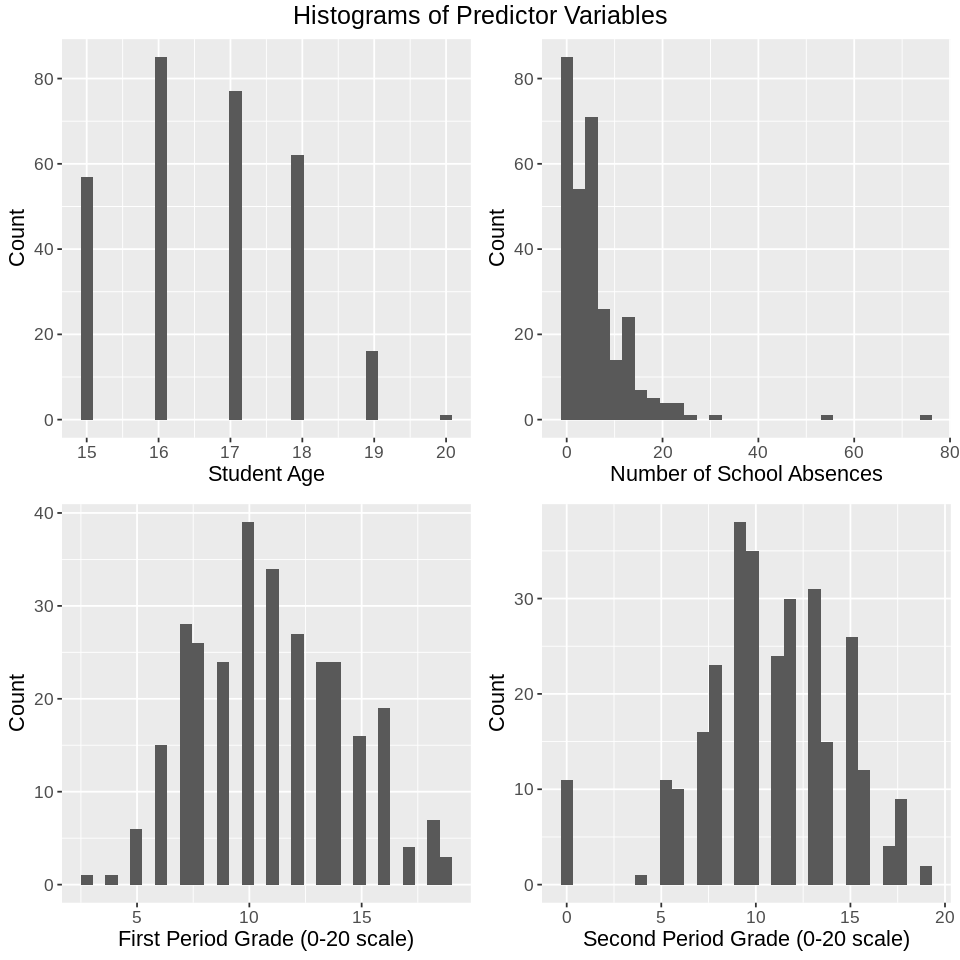

In [8]:
# Plotting histograms for predictors
library(gridExtra)
require(grid)
options(repr.plot.width = 8, repr.plot.height = 8)
grid.arrange(age_hist, absences_hist, G1_hist, G2_hist,
             nrow=2,
             top=textGrob("Histograms of Predictor Variables",
                          gp=gpar(fontsize=15,font=8))
            ) 

### Methods

Of the thirty-two factors and single output target, we will use four factors to predict the final grade.

The factors used are as follows:

* Age (from 15 to 22)
* Number of absences (from 0 to 93)
* First period grade (from 0 to 20)
* Second period grade (from 0 to 20)
* Final grade (from 0 to 20)

From the age, absences, and first and second period grades, we expect to use our data analysis skills with R to predict the final math grade of a secondary school student.

We will use the `ggplot2` library to create a clear visualization of our results.

### Expected outcomes and significance

In this project, we expect to figure out which features can be used to predict a student’s math performance effectively. Based on such findings, we could figure out where students need to improve to increase their performance in math. However, this finding might not work to predict a student's performance in any other class. Thus, predicting a student's performance in classes besides math is a question for the future.

**Reference**

P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.
